In [2]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


from collections import Counter
from scipy.stats import mode

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
full_model_path =  r'C:\Users\k54739\saved_model\simclr_model_epoch_245.pth' 

In [5]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [6]:
# Device setup for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(full_model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_1872\1467178467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(full_model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [8]:
from torchvision.transforms import Resize

# Simclr feature Encoder-decoder


In [9]:
class ImageDataset(Dataset):
    def __init__(self, day7_dir, day10_dir):
        self.day7_files = {os.path.basename(file): os.path.join(day7_dir, file) for file in os.listdir(day7_dir) if file.endswith('.tiff')}
        self.day10_files = {os.path.basename(file): os.path.join(day10_dir, file) for file in os.listdir(day10_dir) if file.endswith('.tiff')}
      
        # Ensure all day7 files have a corresponding day10 file
        self.common_files = list(self.day7_files.keys())
        assert set(self.common_files) <= set(self.day10_files.keys()), "Mismatch between day7 and day10 filenames."
        self.resize = Resize((96, 96))
       

    def __len__(self):
        return len(self.common_files)

    def __getitem__(self, idx):
        filename = self.common_files[idx]
        day7_img_path = self.day7_files[filename]
        day10_img_path = self.day10_files[filename]

        # Load the images
        day7_img = tiff.imread(day7_img_path)
        day10_img = tiff.imread(day10_img_path)

        # Ensure the images have 3 layers (channels)
        if day7_img.shape[0] != 3:
            raise ValueError(f"Day7 image at {day7_img_path} does not have exactly 3 layers. Found shape: {day7_img.shape}.")
        if day10_img.shape[0] != 3:
            raise ValueError(f"Day10 image at {day10_img_path} does not have exactly 3 layers. Found shape: {day10_img.shape}.")

        # Normalize and convert both images
        day7_img = day7_img.astype(np.float32) / 65535.0
        day10_img = day10_img.astype(np.float32) / 65535.0

        # Convert to tensors
        day7_img = torch.tensor(day7_img, dtype=torch.float32)
        day10_img = torch.tensor(day10_img, dtype=torch.float32)

        day7_img = self.resize(day7_img)
        day10_img = self.resize(day10_img)

        return day7_img, day10_img
        #return day7_img, day10_img,day7_img_path,day10_img_path

    
# Specify paths for both day7 and day10 folders
train_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\train\day7'
train_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\train\day10'

test_day7_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\test\day7'
test_day10_dir = r'C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10\test\day10'

# Create the dataset
train_dataset = ImageDataset(train_day7_dir, train_day10_dir) 
val_dataset = ImageDataset(test_day7_dir, test_day10_dir)


In [10]:
batch_size = 16
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [11]:
# Calculate the total number of images in the training dataset
total_images_in_train = len(train_loader.dataset)
print(f"Total number of images: {total_images_in_train}")

Total number of images: 104


In [12]:
# Calculate the total number of images in the training dataset
total_images_in_val = len(val_loader.dataset)
print(f"Total number of images: {total_images_in_val}")

Total number of images: 26


In [13]:
# Print the shape of both pairs and total number of images in one epoch
for i, (input_image, target_image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Input image (day7): {input_image.shape}")
    print(f"  Target image (day10): {target_image.shape}")
    break

Batch 0:
  Input image (day7): torch.Size([16, 3, 96, 96])
  Target image (day10): torch.Size([16, 3, 96, 96])


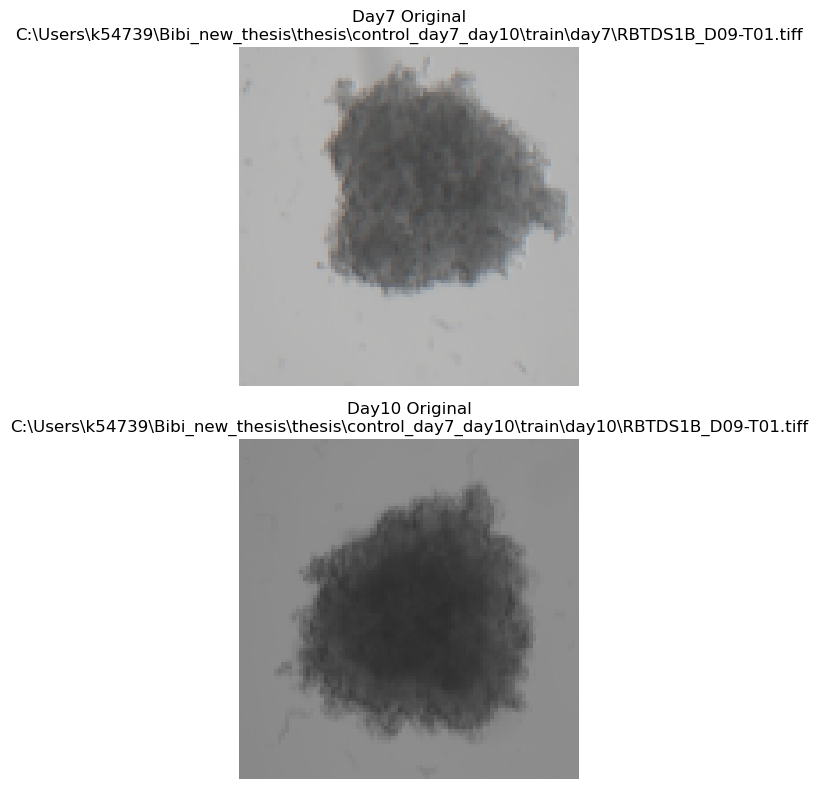

In [32]:
# Retrieve one dataset sample
day7_img, day10_img, day7_img_path, day10_img_path = train_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")


# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")


plt.tight_layout()
plt.show()


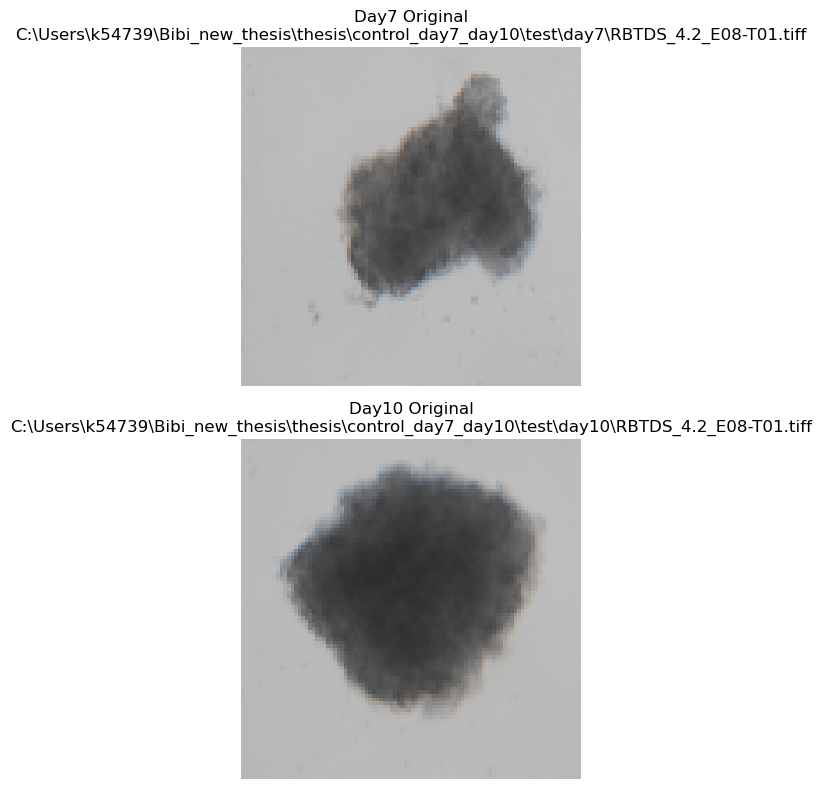

In [33]:
# Retrieve one dataset sample
day7_img, day10_img, day7_img_path, day10_img_path = val_dataset[2]

# Convert tensors to numpy arrays for visualization
day7_img_np = day7_img.permute(1, 2, 0).numpy()
day10_img_np = day10_img.permute(1, 2, 0).numpy()

# Display images with paths
plt.figure(figsize=(12, 8))

# Day7 Original
plt.subplot(2, 2, 1)
plt.imshow(day7_img_np)
plt.title(f"Day7 Original\n{day7_img_path}")
plt.axis("off")


# Day10 Original
plt.subplot(2, 2, 3)
plt.imshow(day10_img_np)
plt.title(f"Day10 Original\n{day10_img_path}")
plt.axis("off")


plt.tight_layout()
plt.show()


class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        
        # Recursively find all .tiff and .tif files in subdirectories
        self.image_files = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(('.tiff', '.tif')):
                    self.image_files.append(os.path.join(root, file))
        
        # Debugging: Print the number of images found
        print(f"Found {len(self.image_files)} image files in directory: {image_dir}")
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        return image


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\control_day7_day10"
dataset = ImageDataset(image_dir=image_dir)

# Define DataLoaders
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

In [14]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all paired images
    day7_feats = []
    day10_feats = []
    
    for batch_day7_imgs, batch_day10_imgs in tqdm(dataloader):
        # Move images to the device
        batch_day7_imgs = batch_day7_imgs.to(device)
        batch_day10_imgs = batch_day10_imgs.to(device)

        # Extract features for day7 and day10 images
        batch_day7_feats = network(batch_day7_imgs)
        batch_day10_feats = network(batch_day10_imgs)

        print(f"Day 7 Batch features shape: {batch_day7_feats.shape}")
        print(f"Day 10 Batch features shape: {batch_day10_feats.shape}")

        # Collect features
        day7_feats.append(batch_day7_feats.detach().cpu())
        day10_feats.append(batch_day10_feats.detach().cpu())

    # Concatenate features
    day7_feats = torch.cat(day7_feats, dim=0)
    day10_feats = torch.cat(day10_feats, dim=0)

    print(f"Day 7 Features shape after concatenation: {day7_feats.shape}")
    print(f"Day 10 Features shape after concatenation: {day10_feats.shape}")

    return day7_feats, day10_feats


In [15]:
# Assuming you have a pre-trained model and DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract features from the training dataset
train_day7_feats, train_day10_feats = prepare_data_features(simclr_model, train_loader)

# Extract features from the validation dataset
val_day7_feats, val_day10_feats = prepare_data_features(simclr_model, val_loader)

# Use the extracted features for your MLP model training
# Example: MLP(input_dim=train_day7_feats.shape[1], output_dim=train_day10_feats.shape[1])


  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:01<00:10,  1.70s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 29%|██▊       | 2/7 [00:03<00:07,  1.54s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 43%|████▎     | 3/7 [00:04<00:05,  1.49s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 57%|█████▋    | 4/7 [00:05<00:04,  1.47s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 71%|███████▏  | 5/7 [00:07<00:02,  1.44s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


 86%|████████▌ | 6/7 [00:08<00:01,  1.44s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Day 7 Batch features shape: torch.Size([8, 512])
Day 10 Batch features shape: torch.Size([8, 512])
Day 7 Features shape after concatenation: torch.Size([104, 512])
Day 10 Features shape after concatenation: torch.Size([104, 512])


 50%|█████     | 1/2 [00:01<00:01,  1.47s/it]

Day 7 Batch features shape: torch.Size([16, 512])
Day 10 Batch features shape: torch.Size([16, 512])


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Day 7 Batch features shape: torch.Size([10, 512])
Day 10 Batch features shape: torch.Size([10, 512])
Day 7 Features shape after concatenation: torch.Size([26, 512])
Day 10 Features shape after concatenation: torch.Size([26, 512])


In [31]:
# Save training features
torch.save(train_day7_feats, 'train_day7_feats.pt')
torch.save(train_day10_feats, 'train_day10_feats.pt')

# Save validation features
torch.save(val_day7_feats, 'val_day7_feats.pt')
torch.save(val_day10_feats, 'val_day10_feats.pt')

print("Features saved successfully!")


Features saved successfully!


In [3]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision

In [4]:
# Load training features
train_day7_feats = torch.load('train_day7_feats.pt')
train_day10_feats = torch.load('train_day10_feats.pt')

# Load validation features
val_day7_feats = torch.load('val_day7_feats.pt')
val_day10_feats = torch.load('val_day10_feats.pt')

print("Features loaded successfully!")


Features loaded successfully!


C:\Users\k54739\AppData\Local\Temp\ipykernel_1712\2577112544.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_day7_feats = torch.load('train_day7_feats.pt')
C:\User

In [5]:
# Print lengths of feature tensors
print(f"Number of training Day 7 features: {len(train_day7_feats)}")
print(f"Number of training Day 10 features: {len(train_day10_feats)}")

print(f"Number of validation Day 7 features: {len(val_day7_feats)}")
print(f"Number of validation Day 10 features: {len(val_day10_feats)}")


Number of training Day 7 features: 104
Number of training Day 10 features: 104
Number of validation Day 7 features: 26
Number of validation Day 10 features: 26


In [6]:
# Print shapes of feature tensors
print(f"Shape of training Day 7 features: {train_day7_feats.shape}")
print(f"Shape of training Day 10 features: {train_day10_feats.shape}")

print(f"Shape of validation Day 7 features: {val_day7_feats.shape}")
print(f"Shape of validation Day 10 features: {val_day10_feats.shape}")


Shape of training Day 7 features: torch.Size([104, 512])
Shape of training Day 10 features: torch.Size([104, 512])
Shape of validation Day 7 features: torch.Size([26, 512])
Shape of validation Day 10 features: torch.Size([26, 512])


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming day1_feats and day2_feats are tensors of shape (N, 512)
train_feature_data = TensorDataset(train_day7_feats, train_day10_feats)
val_feature_data = TensorDataset(val_day7_feats, val_day10_feats)

TrainFeat_dataloader = DataLoader(train_feature_data, batch_size=32, shuffle=True)
ValFeat_dataloader = DataLoader(val_feature_data, batch_size=32, shuffle=True)


In [8]:
class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [9]:
model = FeaturePredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [10]:
def train_and_evaluate(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=50, 
    device='cuda' if torch.cuda.is_available() else 'cpu'
):

    model = model.to(device)
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_inputs, batch_targets in train_loader:
            # Move data to the appropriate device
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            
            # Forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            train_loss += loss.item()
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                # Move data to the appropriate device
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                
                # Forward pass
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        
        # Print epoch stats
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    return history


In [11]:
# Train and evaluate the model
history = train_and_evaluate(
    model=model, 
    train_loader=TrainFeat_dataloader, 
    val_loader=ValFeat_dataloader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=2000
)

Epoch [1/2000], Train Loss: 2.4355, Validation Loss: 2.4543
Epoch [2/2000], Train Loss: 2.3755, Validation Loss: 2.4477
Epoch [3/2000], Train Loss: 2.4001, Validation Loss: 2.4408
Epoch [4/2000], Train Loss: 2.3216, Validation Loss: 2.4336
Epoch [5/2000], Train Loss: 2.4446, Validation Loss: 2.4259
Epoch [6/2000], Train Loss: 2.2950, Validation Loss: 2.4176
Epoch [7/2000], Train Loss: 2.2849, Validation Loss: 2.4085
Epoch [8/2000], Train Loss: 2.3617, Validation Loss: 2.3987
Epoch [9/2000], Train Loss: 2.2644, Validation Loss: 2.3879
Epoch [10/2000], Train Loss: 2.3118, Validation Loss: 2.3759
Epoch [11/2000], Train Loss: 2.3698, Validation Loss: 2.3627
Epoch [12/2000], Train Loss: 2.4130, Validation Loss: 2.3479
Epoch [13/2000], Train Loss: 2.3804, Validation Loss: 2.3316
Epoch [14/2000], Train Loss: 2.2564, Validation Loss: 2.3134
Epoch [15/2000], Train Loss: 2.2188, Validation Loss: 2.2935
Epoch [16/2000], Train Loss: 2.2152, Validation Loss: 2.2716
Epoch [17/2000], Train Loss: 2.20

In [ ]:
#val loss minimum = 0.85

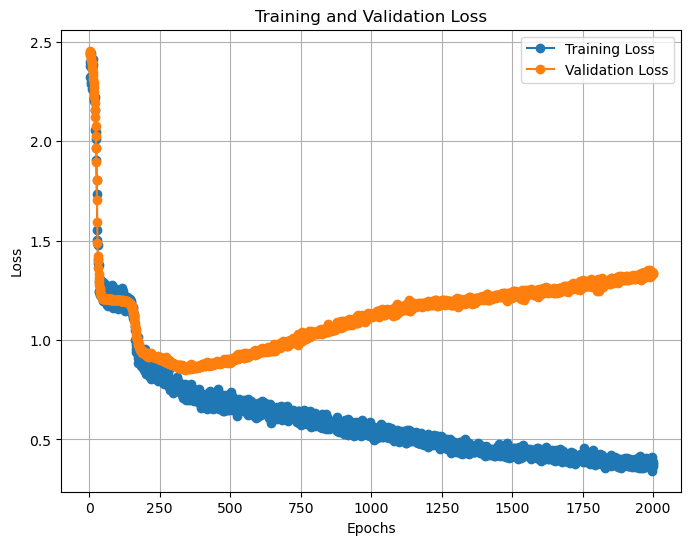

In [12]:
import matplotlib.pyplot as plt

def plot_losses(history):
    """
    Plots training and validation losses over epochs.

    Args:
        history (dict): Dictionary containing 'train_loss' and 'val_loss' lists.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history['train_loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_losses(history)
